Projeto


In [ ]:
#!pip install SoccerNet --upgrade
#!pip install transformers
#!pip install ffmpeg
#!pip install torch
#!pip install ffmpeg-python
#!pip install accelerate
#!pip instal scikit-learn
#!pip install matplotlib

### Mount drive


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


### Import dataset from SoccerNet


In [ ]:
from SoccerNet.Downloader import SoccerNetDownloader

password = "s0cc3rn3t"

def unlabeled_dataset(LocalDirectory):
    myDownloader = SoccerNetDownloader(LocalDirectory=LocalDirectory)
    myDownloader.password = password
    myDownloader.downloadGames(files=["1_224p.mkv", "2_224p.mkv"], split=["train","valid","test","challenge"])

def labeled_dataset(LocalDirectory):
    myDownloader = SoccerNetDownloader(LocalDirectory="Football-Dataset/")
    myDownloader.password = password
    myDownloader.downloadGames(files=["Labels-v2.json"], split=["train","valid","test"])

unlabeled_dataset("Football-Dataset/")
#labeled_dataset("Football-Dataset/")

### Import dependencies


In [2]:
import ffmpeg
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
import torch
import os
import shutil
import time
import pandas as pd
import numpy as np
import json

### Building our model


In [2]:
def build_model(model_id):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
    print("Running model on", device)

    model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, use_safetensors=True
                                                      )
    model.to(device)

    processor = AutoProcessor.from_pretrained(model_id, language="en")

    pipe = pipeline(
        "automatic-speech-recognition",
        model=model,
        tokenizer=processor.tokenizer,
        feature_extractor=processor.feature_extractor,
        max_new_tokens=128,
        chunk_length_s=30,
        batch_size=16,
        return_timestamps=True,
        torch_dtype=torch_dtype,
        device=device,
    )

    return pipe

model_id = "openai/whisper-large" 
model_ids = ["openai/whisper-base", "openai/whisper-small", "openai/whisper-medium", "openai/whisper-large", "openai/whisper-large-v2", "openai/whisper-large-v3"]
pipe = build_model(model_id=model_id)

### Fragment audio and translate


In [4]:
# environment variables
#local_dir = "drive/MyDrive/DTX/Football-Dataset"
dir = "Football-Dataset/england_epl/"

def update_txt_file(text, path):
    with open(path, "w", encoding="utf-8") as f:
        f.write(text)


def audio_to_text(pipe, model_id):
  for year in os.listdir(dir):
      games = os.path.join(dir, year)
      for game in os.listdir(games):
          if game != ".ipynb_checkpoints":
              game_dir = os.path.join(games, game)
              frag1_dir = os.path.join(game_dir, "fragments_1_224p")
              frag2_dir = os.path.join(game_dir, "fragments_2_224p")

              for audioFrag1 in os.listdir(frag1_dir):
                result = pipe(frag1_dir + '/' + audioFrag1, return_timestamps=True,  generate_kwargs = {"language": "english", "task": "translate"})
                update_txt_file(result['text'], frag1_dir + f'/{audioFrag1[:-4]}__{model_id[7:]}.txt')

              for audioFrag2 in os.listdir(frag2_dir):
                result = pipe(frag2_dir + '/' + audioFrag2, return_timestamps=True,  generate_kwargs = {"language": "english", "task": "translate"})
                update_txt_file(result['text'], frag2_dir + f'/{audioFrag2[:-4]}__{model_id[7:]}.txt')


def clear_nonvideos(path):
    for t in os.listdir(path):
        if os.path.isdir(path + '/' + t):
          shutil.rmtree(path + '/' + t)
        else:
          if not t.endswith(".mkv"):
             os.remove(path + '/' + t)


def fragment_dataset_audio(audio_cut_length, offset):
  for year in os.listdir(dir):
      games = os.path.join(dir, year)
      for game in os.listdir(games):
          game_dir = os.path.join(games, game)

          if game != ".ipynb_checkpoints":
            clear_nonvideos(game_dir)
            for videoFile in os.listdir(game_dir):
                pathVideo = game_dir + "/" + videoFile
                videoFragments = game_dir + f"/fragments_{videoFile[:-4]}"
                
                # este if não está a funcionar como é suposto
                if not os.path.exists(videoFragments):
                  print("Criei pasta: ", videoFragments)
                  os.mkdir(videoFragments)

                duration = float(ffmpeg.probe(pathVideo)["format"]["duration"])
                steps = duration/audio_cut_length
                for n in range(int(steps)+1):
                  try:
                    ffmpeg.input(pathVideo, ss=(n*audio_cut_length)-offset, to=(n+1)*audio_cut_length).output(videoFragments + f"/fragment_{n}.wav",ar=16000).run(quiet=True, overwrite_output=True)
                  except ffmpeg.Error as e:
                    print("Output: ", e.stdout)
                    print("Error: ", e.stderr)

#fragment_dataset_audio(audio_cut_length=30, offset=2)
#audio_to_text(pipe=pipe, model_id=model_id)

### Benchmark


In [9]:

def get_fragment_zero(m):
   with open(dir+f"2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/fragments_1_224p/fragment_0__{m[7:]}.txt", "r", encoding="utf-8") as f:
      return f.readline()


def sec_to_minsec(sec):
   
  min = int(sec / 60)
  sec2 = int((sec/60 - min) * 60)
  if sec2 < 10:
     sec2 = f"0{sec2}"
  else:
     sec2 = str(sec2)
  return f"{min}:"+sec2
   
   
def benchmark(flag):
    benchmarks_times = {} 
    benchmarks_frags = {}

    for m in model_ids:
        fragment_dataset_audio(audio_cut_length=30, offset=2)
        start_time = time.time()
        pipe = build_model(model_id=m)
        audio_to_text(pipe, m)
        benchmarks_times[m] = sec_to_minsec(time.time() - start_time)
        frag0 = get_fragment_zero(m)
        benchmarks_frags[m] = frag0

    
    json1 = []


    for model in benchmarks_times:
        dados={"jogo": "2015-02-21 - 18-00 Chelsea 1 - 1 Burnley", "model": model, "run_time_per_game": benchmarks_times[model], "transcricao": benchmarks_frags[model]}
        json1.append(dados)

    with open(f"benchmark_{flag}.json", "w") as f:
        json.dump(json1,f,indent=2)

    



#nao correr 
#benchmark("CPU")

Criei pasta:  Football-Dataset/england_epl/2014-2015\2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/fragments_1_224p
Criei pasta:  Football-Dataset/england_epl/2014-2015\2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/fragments_2_224p
Running model on cpu


config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

e:\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\HugoRocha\.cache\huggingface\hub\models--openai--whisper-large-v3. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Build our own dataset


In [35]:
def build_labeled_dataset():
    base_path = "Football-Dataset/england_epl/"
    id = 1
    
    f = open("dataframe.csv", "w")
    f.write("id;league;game;fragment_start_time;fragment_end_time;commentary;model_id;label;\n")
    f.close()
           
    for year in os.listdir(base_path):
        games = os.path.join(base_path, year)
        for game in os.listdir(games):
            fragments_1 = os.path.join(games, game, "fragments_1_224p")
            fragments_2 = os.path.join(games, game, "fragments_2_224p")

            id = write_fragments(folder=fragments_1, year=year, league="england_epl", game=game, half=1, id=id)
            id = write_fragments(folder=fragments_2, year=year, league="england_epl", game=game, half=2, id=id)

    print("id: ", id)
"""
folder - path to the folder that has the fragments
league - league folder in which the game is inserted
year   - year in whice the game is inserted
game   - name of the correspondent game
half   - 1 if it is 1st half, 2 if it is 2nd half
audio_cut_length - size of the fragments
offset - size of the offset we are using to catch some audio from the last fragment.
"""
def write_fragments(folder, league, year, game, half, id, audio_cut_length=30, offset=2):    
    model_id = "openai/whisper-base" #"openai/whisper-large-v3" 
    num_transcriptions = len(os.listdir(folder))//2
    
    # ex: (fragment_20.txt, 20)  -> (fragment file name, fragment_number)
    model_id = model_id[7:]
    fragment_file_names = [("fragment_" + str(i) + f"__{model_id}.txt", i) for i in range(num_transcriptions)]

    labels = os.path.join("Football-Dataset", league, year, game, "Labels-v2.json")

    l = open(labels, "r", encoding='utf-8')
    data = json.load(l)

    with open("dataframe.csv", 'a') as df:
        for fragment_file in fragment_file_names:
            fragment_path = os.path.join(folder, fragment_file[0])
            # These values are counted in seconds
            start_time = fragment_file[1] * audio_cut_length - offset
            end_time = (fragment_file[1]+1) * audio_cut_length

            f = open(fragment_path, "r")
            commentary = f.read()
            f.close()
 
            for annotation in data['annotations']:
                annotation_half = int(annotation['gameTime'][0]) 
                if annotation_half == half:
                    annotation_min =  int(annotation['gameTime'][-5:-3])
                    annotation_sec = int(annotation['gameTime'][-2:])
                    
                    annotation_min_to_sec = annotation_min*60 + annotation_sec 
                    if start_time < annotation_min_to_sec and end_time > annotation_min_to_sec:
                        label =  annotation['label']
                        break
            
            
            if label in ["Shots on target", "Goal", "Offside"]:
                label = "Highlight"
            else:
                label = "Non-Highlight"
                
            row = str(id) + ";" + league + ";" + game + ";" + str(start_time) + ";" + str(end_time) + ";" + commentary + ";" + model_id + ";" + label + "\n"
            df.write(row)
            id+=1
            
    return id   
               

build_labeled_dataset()



id:  750


### Evaluate the model


In [36]:
#Dar load a base de dados
from sklearn import metrics
import matplotlib.pyplot as plt

colabPath = '/content/drive/MyDrive/DTX/dataframe.csv'
localPath = 'dataframe.csv'
dados = pd.read_csv(localPath, encoding='utf-8' , sep=';', header = 0)

#Fazer o modelo para cada comentario da linha
classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
)
candidate_labels = ["Highlight", "Non-Highlight"]

for indice, linha in dados.iterrows():
  sequence_to_classify = linha['commentary']
  res = classifier(sequence_to_classify, candidate_labels)

  dados.at[indice, 'categoria'] = res['labels'][0]
  dados.at[indice, 'confianca'] = res['scores'][0]
  
  print("Comentário: ", sequence_to_classify)
  print("Categoria: ", res['labels'][0], "Classificação: ", res['scores'][0])
  print("Valor suposto: ", dados.at[indice, 'label'], '\n\n')
  

Comentário:   the ball and their change get today. They give a left to right in the first half. Early touch for Matt target. Hello dropping deep and it's a wonderful incisive ball. In the jury to the opening once of the game. No penalty says the referee. Massive incident just 20 seconds into the match. Wow.
Categoria:  Highlight Classificação:  0.662632167339325
Valor suposto:  Non-Highlight 


Comentário:   the the
Categoria:  Highlight Classificação:  0.6044378280639648
Valor suposto:  Non-Highlight 


Comentário:   the match before he's had a chance to get his eye and see whether he got it right. Yeah, I think he has his gone down very easy there. I know the arm comes across onto his shoulder but for me, he's gone down far too easily. What a story that would have been for the jury. the first of the second of the second of the second of the second of the second of the second of the second of the second of the second of the second of the second of the second of the second of the secon

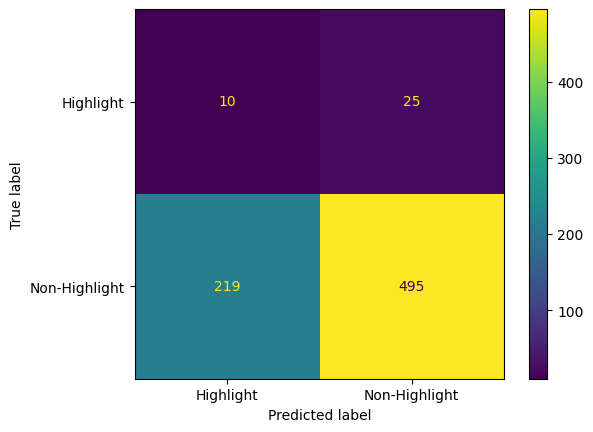

Matriz de Confusão:
[[ 10  25]
 [219 495]]

Percentagem de acerto: 67.42%


In [37]:
#print(dados)

#Se quisermos salvar as colunas no dataframe
#dados.to_csv(caminho_arquivo, index=False)

# Construir a matriz de confusão
confusion_matrix = metrics.confusion_matrix(dados['label'], dados['categoria'])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=candidate_labels)
cm_display.plot()
plt.show()

# Calcular as percentagens de acerto
total_predicoes = np.sum(confusion_matrix)
predicoes_corretas = np.trace(confusion_matrix)
percentagem_acerto = predicoes_corretas / total_predicoes * 100

# Exibir a matriz de confusão e a percentagem de acerto
print("Matriz de Confusão:")
print(confusion_matrix)
print("\nPercentagem de acerto: {:.2f}%".format(percentagem_acerto))